### ARIMA Model Example - Jason Brownlee
* https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
* https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read in csv file and parse Month to datetime
# shampoo.Month = pd.to_datetime(shampoo.Month)
shampoo = pd.read_csv("Resources/ShampooData.csv", parse_dates=['Month'])

In [3]:
shampoo.head()
shampoo.dtypes
# shampoo.isna().sum()

Month    datetime64[ns]
Sales           float64
dtype: object

In [4]:
shampoo.head()

,Month,Sales
0,2017-01-01,266.0
1,2017-02-01,145.9
2,2017-03-01,183.1
3,2017-04-01,119.3
4,2017-05-01,180.3


In [5]:
print(shampoo.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Month   36 non-null     datetime64[ns]
 1   Sales   36 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 704.0 bytes
None


### Checking Stationarity - methods
    1. Basic plot
    2. Plotting rolling statistics
    3. Augmented Dickey-Fuller test
    4. KPSS test (Kwiatkowski-Phillips-Schmidt-Shin)

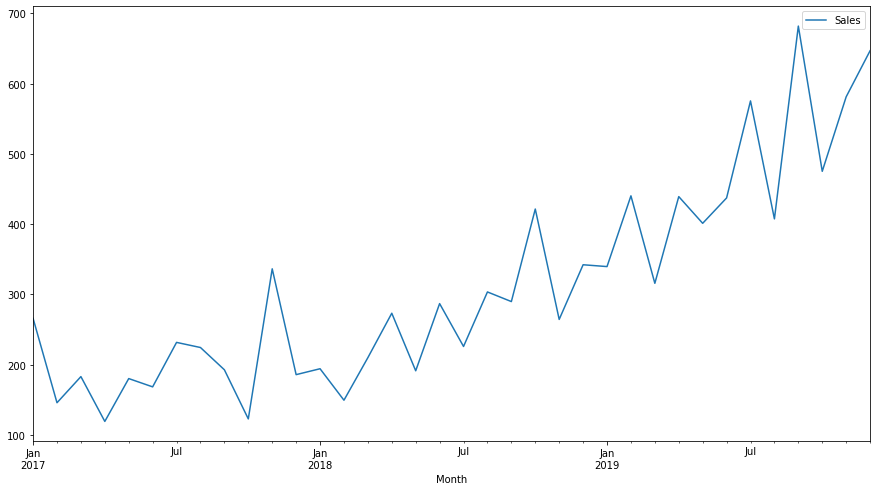

In [5]:
# 1. BASIC PLOT

shampoo.plot(x='Month', y='Sales', figsize=(15,8))


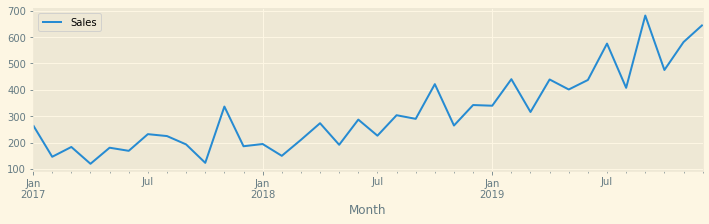

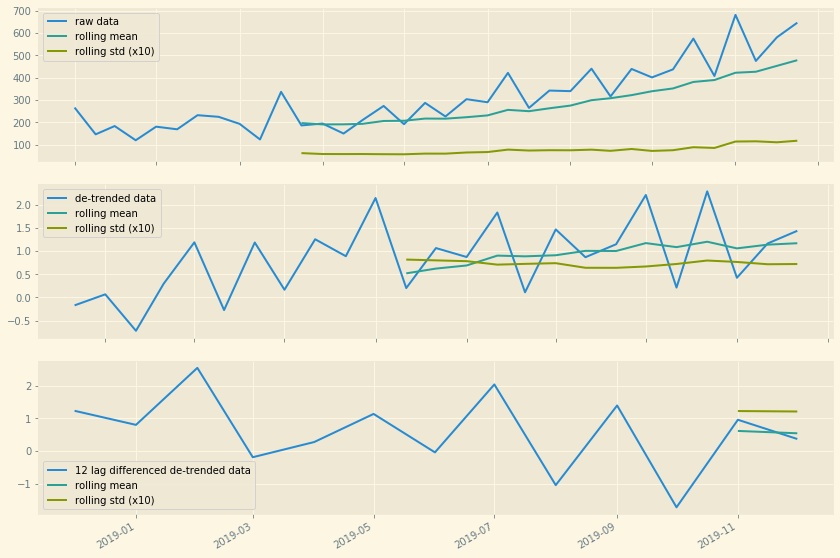

In [34]:
# 2. PLOT ROLLING STATS

import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
plt.style.use('Solarize_Light2')

df = pd.DataFrame(shampoo)
df2= df.set_index('Month')

train = df2.iloc[:-10, :]     # up to last 10
test = df2.iloc[-10:, :]      # last 10 data point

pred = test.copy()
df2.plot(figsize=(12,3));


df2['z_data'] = (df2['Sales'] - df2.Sales.rolling(window=12).mean()) / df2.Sales.rolling(window=12).std()
df2['zp_data'] = df2['z_data'] - df2['z_data'].shift(12)

def plot_rolling(df2):
    fig, ax = plt.subplots(3,figsize=(12, 9))
    
    ax[0].plot(df2.index, df2.Sales, label='raw data')
    ax[0].plot(df2.Sales.rolling(window=12).mean(), label="rolling mean");
    ax[0].plot(df2.Sales.rolling(window=12).std(), label="rolling std (x10)");
    ax[0].legend()

    ax[1].plot(df2.index, df2.z_data, label="de-trended data")
    ax[1].plot(df2.z_data.rolling(window=12).mean(), label="rolling mean");
    ax[1].plot(df2.z_data.rolling(window=12).std(), label="rolling std (x10)");
    ax[1].legend()

    ax[2].plot(df2.index, df2.zp_data, label="12 lag differenced de-trended data")
    ax[2].plot(df2.zp_data.rolling(window=12).mean(), label="rolling mean");
    ax[2].plot(df2.zp_data.rolling(window=12).std(), label="rolling std (x10)");
    ax[2].legend()

    plt.tight_layout()
    fig.autofmt_xdate()
    
plot_rolling(df2)

In [31]:
# 3. AUGMENTED DICKEY-FULLER TEST

from statsmodels.tsa.stattools import adfuller

print(" > Is the data stationary ?")
dftest = adfuller(df2.Sales, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))


 > Is the data stationary ?
Test statistic = 3.060
P-value = 1.000
Critical values :
	1%: -3.7238633119999998 - The data is not stationary with 99% confidence
	5%: -2.98648896 - The data is not stationary with 95% confidence
	10%: -2.6328004 - The data is not stationary with 90% confidence


In [37]:
# 4. KPSS

from statsmodels.tsa.stattools import kpss

print(" > Is the data stationary ?")
dfkpsstest = kpss(np.log(df2.Sales), 'ct')
print("Test statistic = {:.3f}".format(dfkpsstest[0]))
print("P-value = {:.3f}".format(dfkpsstest[1]))
print("Critical values :")
for k, v in dfkpsstest[3].items():
    print("\t{}: {}".format(k, v))

 > Is the data stationary ?
Test statistic = 0.149
P-value = 0.047
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


C:\Users\Lenovo\Anaconda3\envs\PythonData\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


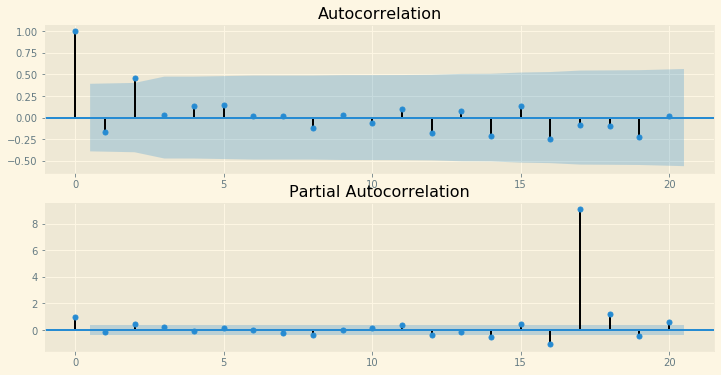

In [39]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(df2.z_data.dropna(), ax=ax[0], lags=20)
ax[1] = plot_pacf(df2.z_data.dropna(), ax=ax[1], lags=20)

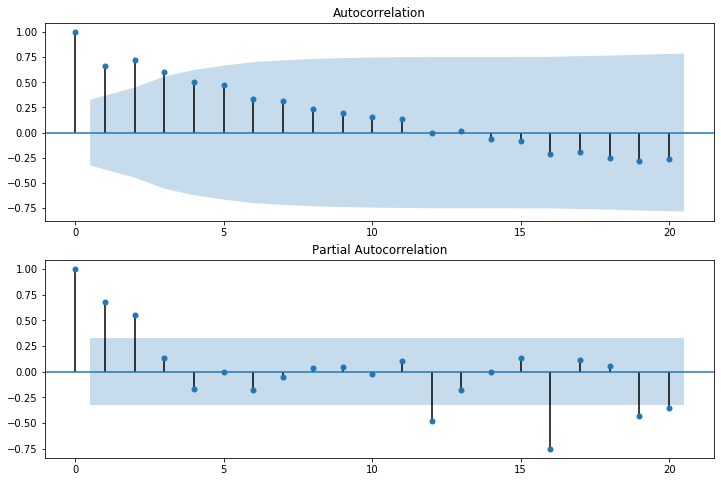

In [7]:
# Plot ACF (MA model) and PACF (AR model)
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(shampoo['Sales'], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(shampoo['Sales'], lags=20, ax=ax2)
plt.show()

In [8]:
# fit model

from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(shampoo["Sales"], order=(2,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())


                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   35
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -197.814
Method:                       css-mle   S.D. of innovations             67.833
Date:                Tue, 21 Jul 2020   AIC                            403.628
Time:                        19:59:38   BIC                            409.849
Sample:                             1   HQIC                           405.775
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            11.6504      4.907      2.374      0.018       2.034      21.267
ar.L1.D.Sales    -1.0223      0.167     -6.109      0.000      -1.350      -0.694
ar.L2.D.Sales    -0.3655      0.167     

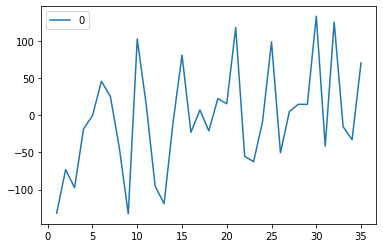

In [9]:
# plot residual errors. We get a line plot of the residual errors, 
# suggesting that there may still be some trend information not captured by the model.

from pandas import DataFrame

residuals = DataFrame(model_fit.resid)
residuals.plot()

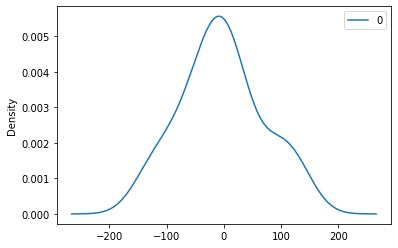

In [10]:
# We get a density plot of the residual error values, 
# suggesting the errors are Gaussian, but may not be centered on zero.

residuals.plot(kind='kde')


In [11]:
# The distribution of the residual errors is displayed. The results show that 
# indeed there is a bias in the prediction (a non-zero mean in the residuals).

print(residuals.describe())

                0
count   35.000000
mean    -3.927333
std     71.118405
min   -132.795705
25%    -47.082981
50%     -8.308474
75%     23.822062
max    133.295961


In [16]:
# Example of a rolling forecast with the ARIMA model in Python.

from sklearn.metrics import mean_squared_error

# Split train and test data
X = shampoo["Sales"].values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]

# create the model using 70% of data
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('test_predicted=%f, test_actual_observation=%f' % (yhat, obs))

# Calculate MSE    
error = mean_squared_error(test, predictions)
rmse = np.sqrt(error)
print(" ")
print('Test MSE: %.3f' % error)
print('Test RMSE: %.3f' % rmse)



test_predicted=337.349540, test_actual_observation=440.400000
test_predicted=378.283318, test_actual_observation=315.900000
test_predicted=413.321038, test_actual_observation=439.300000
test_predicted=370.978181, test_actual_observation=401.300000
test_predicted=425.757106, test_actual_observation=437.400000
test_predicted=429.401365, test_actual_observation=575.500000
test_predicted=474.580654, test_actual_observation=407.600000
test_predicted=542.710044, test_actual_observation=682.000000
test_predicted=480.813952, test_actual_observation=475.300000
test_predicted=634.327308, test_actual_observation=581.300000
test_predicted=561.051489, test_actual_observation=646.900000
 
Test MSE: 6516.921
Test RMSE: 80.727


In [ ]:
# plot
pyplot.plot(test, color = 'blue')
pyplot.plot(predictions, color='red')
pyplot.show()

### Hypertuning


In [ ]:
import warnings
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
 
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
 
# load dataset
series = shampoo["Sales"]
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)